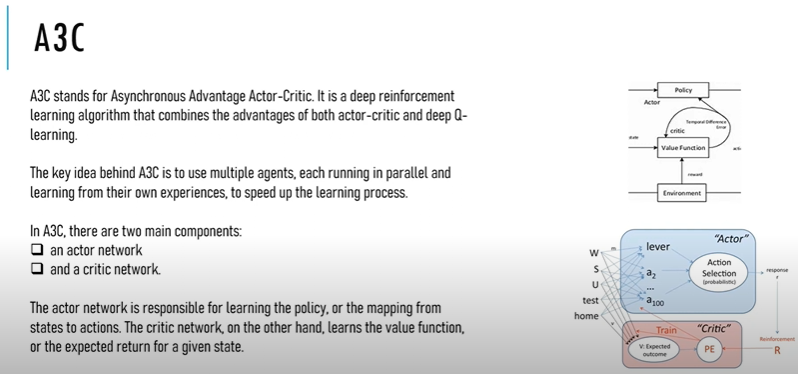

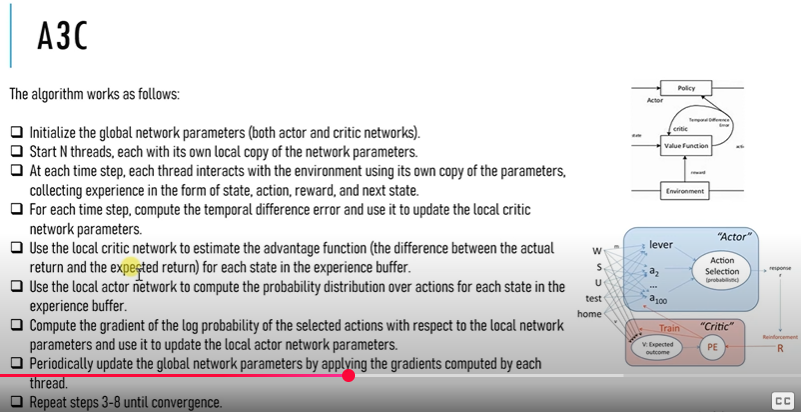

In [1]:
import gym
import numpy as np
import tensorflow as tf
import threading

In [3]:
num_threads = 4
max_episodes = 10000
gamma = .99
learning_rate = 0.01
entropy_beta=0.01

env_name ='CartPole-v1'
env = gym.make(env_name)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [4]:
state_size

4

In [5]:
action_size

2

In [6]:
global_model = tf.keras.Sequential([tf.keras.layers.Dense(32, activation='relu', input_shape=(state_size,)),
                                   tf.keras.layers.Dense(action_size, activation='softmax')])
global_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy')

d:\a27_YEARS_OLD\rainforcement_learning\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
class Worker(threading.Thread):
    def __init__(self, thread_id, global_model):
        super(Worker, self).__init__()
        self.thread_id = thread_id
        self.global_model = global_model
        self.env = gym.make(env_name)
        self.state_size = state_size
        self.action_size = action_size
        
        self.local_network = tf.keras.Sequential([tf.keras.layers.Dense(32, activation='relu', input_shape=(state_size,)),
                                   tf.keras.layers.Dense(action_size, activation='softmax')])
        
        self.local_network.set_weights(self.global_model.get_weights())
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        
        
    def run(self):
        for episode in range(max_episodes):
            state = self.env.reset()[0]
            done = False
            episode_states = []
            episode_actions = []
            episode_rewards = []
            episode_reward = 0
            
            while not done:
                logits = self.local_network(tf.convert_to_tensor([state], dtype=tf.float32))
                action = np.random.choice(action_size, p = np.squeeze(logits.numpy()))
                
                
                next_state, reward, done, _ = self.env.step(action)
                episode_reward += reward
                
                episode_states.append(state)
                episode_actions.append(action)
                episode_rewards.append(reward)
                
                state = next_state
                
                if done:
                    discounted_rewards = self.discounted_rewards(episode_rewards)
                    
                    self.update_global(episode_states, episode_actions, discounted_rewards)
                    self.local_network.set_weights(self.global_model.get_weights())
                    print("Thread:", self.thread_id, "Episode:", episode, "Reward:", episode_reward)
                    break
                    
    def discounted_rewards(self, rewards):
        discounted_rewards = np.zeros_like(rewards)
        running_total = 0
        for i in reversed(range(len(rewards))):
            running_total = running_total* gamma + rewards[i]
            discounted_rewards[i] = running_total
        return discounted_rewards


    def update_global(self, states, actions, discounted_rewards):
        with tf.GradientTape() as tape:
            total_loss = self.calculate_t_loss(states, actions, discounted_rewards)
        gradients = tape.gradient(total_loss, self.local_network.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.local_network.trainable_variables))

    def calculate_t_loss(self, states, actions, discounted_rewards):
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        discounted_rewards = tf.convert_to_tensor(discounted_rewards, dtype=tf.float32)
        
        
        logits = self.local_network(states)
        probs = tf.nn.softmax(logits)
        
        cross_entropy = tf.keras.losses.sparse_categorical_crossentropy(actions, logits, from_logits=True)
        policy_loss = tf.reduce_mean(cross_entropy * discounted_rewards)
        
        values = self.local_network(states)
        value_loss = tf.reduce_mean(tf.square(discounted_rewards - values))
        
        entropy_loss = tf.reduce_mean(tf.reduce_mean(probs * tf.math.log(probs), axis=1))
        total_loss = -policy_loss + 0.5 * value_loss - 0.01 * entropy_loss
        return total_loss

In [8]:
workers = []
for i in range(num_threads):
    worker = Worker(i, global_model)
    workers.append(worker)
    
for worker in workers:
    worker.start()
    
for worker in workers:
    worker.join()

Exception in thread Thread-7:
Traceback (most recent call last):
  File "d:\a27_YEARS_OLD\rainforcement_learning\venv\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "C:\Users\lenovo\AppData\Local\Temp\ipykernel_15496\1162592690.py", line 31, in run
  File "d:\a27_YEARS_OLD\rainforcement_learning\venv\Lib\site-packages\gym\wrappers\time_limit.py", line 50, in step
    observation, reward, terminated, truncated, info = self.env.step(action)
                                                       ^^^^^^^^^^^^^^^^^^^^^
  File "d:\a27_YEARS_OLD\rainforcement_learning\venv\Lib\site-packages\gym\wrappers\order_enforcing.py", line 37, in step
    return self.env.step(action)
           ^^^^^^^^^^^^^^^^^^^^^
  File "d:\a27_YEARS_OLD\rainforcement_learning\venv\Lib\site-packages\gym\wrappers\env_checker.py", line 37, in step
Exception in thread Thread-5:
Traceback (most recent call last):
  File "d:\a27_YEARS_OLD\rainforcement_learning\venv\Lib\threading.py", line 1045, i